### Import Libraries

In [1]:
import os
import cv2
import copy
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
random_seed = 42
torch.manual_seed(random_seed);

In [4]:
torch.set_printoptions(edgeitems=5)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()

In [7]:
device

device(type='cuda')

### Step 1a) Fetch the LFW dataset

#### Option i) Fetch the kaggle downloaded LFW dataset

In [9]:
#main_dir = '../datasets/LFW' #For Ubuntu
main_dir = 'D:/Face/LFW' #For Windows
data_dir = main_dir + "/lfw-deepfunneled/lfw-deepfunneled"

print(os.listdir(main_dir))
classes = os.listdir(data_dir)
print(len(classes))

['lfw-deepfunneled', 'lfw_allnames.csv', 'lfw_home', 'lfw_readme.csv', 'matchpairsDevTest.csv', 'matchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'mismatchpairsDevTrain.csv', 'pairs.csv', 'people.csv', 'peopleDevTest.csv', 'peopleDevTrain.csv']
5749


In [10]:
img_Aaron_Eckhart = os.listdir(data_dir + "/Aaron_Eckhart")
print('No. of training examples for Aaron_Eckhart:', len(img_Aaron_Eckhart))
print(img_Aaron_Eckhart[:])

No. of training examples for Aaron_Eckhart: 1
['Aaron_Eckhart_0001.jpg']


In [11]:
dataset = ImageFolder(data_dir, transform=ToTensor())

In [12]:
len(dataset)

13233

In [ ]:
print(dataset.classes)

In [13]:
img, label = dataset[13232]
print(img.shape, label)

torch.Size([3, 250, 250]) 5748


Text(0.5, 1.0, 'label = 667')

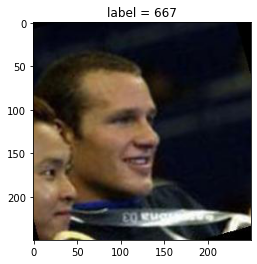

In [14]:
img, label = dataset[1500]
#img = torch.reshape(img, (size2, size2, 3))
img = img.permute(1, 2, 0)

plt.imshow(img)
plt.title('label = ' + str(label))

Text(0.5, 1.0, 'label = 0')

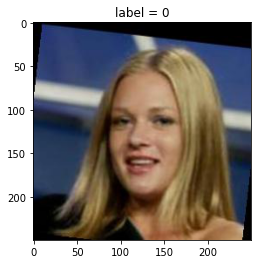

In [15]:
img, label = dataset[0]
#img = torch.reshape(img, (size2, size2, 3))
img = img.permute(1, 2, 0)

plt.imshow(img)
plt.title('label = ' + str(label))

#### Option ii) Fetch the sklearn library LFW dataset

In [8]:
from sklearn.datasets import fetch_lfw_pairs

In [9]:
lfw_people = fetch_lfw_pairs(data_home = "D:/Face/send/", subset='test', color=True, resize=1)

In [10]:
pairs = lfw_people.pairs
targets = lfw_people.target

In [11]:
pairs.shape, targets.shape

((1000, 2, 125, 94, 3), (1000,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


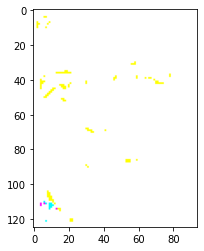

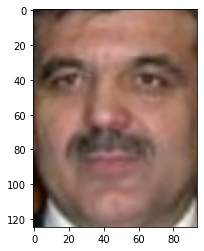

actual:  1


In [30]:
idx = 0
pair = pairs[idx]
img1 = pair[0]
img2 = pair[1]

plt.imshow(img1)
plt.show()

plt.imshow(img2/255)
plt.show()

print("actual: ", targets[idx])

In [31]:
img1.shape

(125, 94, 3)

In [72]:
idx = 0
pair = pairs[idx]
t = torch.from_numpy(pair)
print(t.shape)
t2 = torch.permute(t, (0, 3, 1, 2))
print(t2.shape)

tra = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
     ])
img1 = pair[0]
img2 = pair[1]

#img1 = img1.astype(int)
img1 = img1/255
img2 = img2/255

print(img1.shape)
t3 = tra(img1)
print(t3.shape)

t4 = tra(img2)

torch.Size([2, 125, 94, 3])
torch.Size([2, 3, 125, 94])
(125, 94, 3)
torch.Size([3, 125, 94])


In [73]:
torch.max(t3), torch.min(t3)

(tensor(1.), tensor(-1.))

In [78]:
new_pair = torch.stack((t3, t4), 0)
new_pair.shape

torch.Size([2, 3, 125, 94])

In [ ]:
class ArcFaceDataset(Dataset):
    def __init__(self, root_dir):
        super(ArcFaceDataset, self).__init__()

        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        
        self.root_dir = root_dir
        #root_dir2 = "D:/Face/faces_emore/" #"faces_emore/"
        
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys)) #List of numbers 1 .... 5908396

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

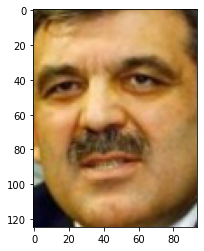

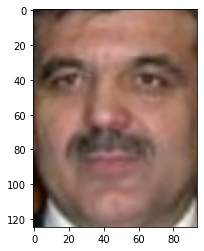

actual:  1


In [13]:
for idx in range(1000):
    pair = pairs[idx]
    img1 = pair[0]
    img2 = pair[1]

    plt.imshow(img1/255)
    plt.show()

    plt.imshow(img2/255)
    plt.show()

    print("actual: ", targets[idx])
    break

#### Option iii) Fetch the mx LFW dataset

### Step 2a) Model Architecture - Network

In [14]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [15]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [16]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [17]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [18]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [19]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                        nn.ReLU(inplace=True),
                        nn.AdaptiveAvgPool2d(1),
                        #nn.AvgPool2d(kernel_size=2, stride=2),
                        Flatten(),
                        nn.Linear(n_channels[n_groups]*2, 512)
                       ]
        #self.fc = nn.Linear(512, n_classes)
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        embed = self.features(x)
        #print(embed.shape)
        return embed #self.fc(embed)

In [20]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [48]:
def test():
    net = ResNet50(50)
    x = torch.randn(2, 3, 224, 224)
    y = net(x)
    print(y.shape)
    print(y)
    print(y[0].shape)
    to_device(net, device)
    summary(net, input_size = (3, 62, 47), batch_size = -1)
    return net

In [49]:
model_net = test()

torch.Size([2, 512])
tensor([[ 0.0708,  0.1919, -0.1002,  0.0012, -0.0242,  ..., -0.1195, -0.2629,
          0.0781,  0.0734,  0.2227],
        [ 0.0010,  0.1380, -0.2101, -0.0303,  0.0257,  ...,  0.0926, -0.1516,
          0.0258,  0.0023,  0.2089]], grad_fn=<AddmmBackward0>)
torch.Size([512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 24]           9,408
         MaxPool2d-2           [-1, 64, 16, 12]               0
       BatchNorm2d-3           [-1, 64, 16, 12]             128
            Conv2d-4          [-1, 256, 16, 12]          16,384
            Conv2d-5           [-1, 64, 16, 12]           4,096
       BatchNorm2d-6           [-1, 64, 16, 12]             128
              ReLU-7           [-1, 64, 16, 12]               0
            Conv2d-8           [-1, 64, 16, 12]          36,864
       BatchNorm2d-9           [-1, 64, 16, 12]             128

In [21]:
loaded_model = ResNet152(85742)
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [22]:
summary(loaded_model, input_size = (3, 250, 250), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
            Conv2d-4          [-1, 256, 63, 63]          16,384
            Conv2d-5           [-1, 64, 63, 63]           4,096
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
           Conv2d-11          [-1, 256, 63, 63]          16,384
         ResBlock-12          [-1, 256, 63, 63]               0
      BatchNorm2d-13          [-1, 256, 63, 63]             512
           Conv2d-14           [-1, 64,

In [23]:
#model.layers

In [24]:
# #model = ResNet50(85742)

# for param in loaded_model.parameters():
#     param.requires_grad = False
#     #print(param.shape)
#     #print('----------------------------')
#     #model.fc = nn.Linear(5749, 8)
#     #print("After addition: ", param.shape)

### Step 2b) Loss Function

In [ ]:
class CosFace(nn.Module):
    def __init__(self, in_features=512, out_features=5749, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, p=2.0, dim=1) #l2_norm(logits, axis=1)
        kernel_norm = F.normalize(self.kernel, p=2.0, dim=0) #l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(labels != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1]).to(device)
        m_hot.scatter_(1, labels[index, None], self.m).to(device)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [ ]:
new_logits = CosFace()

In [ ]:
to_device(new_logits, device)
#new_logits.to(device)

In [ ]:
checkpoint = torch.load("../Checkpoints/model_06_Mar_25.pt")
loaded_model.load_state_dict(checkpoint['model_state_dict'])
#opt1 = checkpoint['model_optimizer_state_dict']
#opt2 = checkpoint['fc_optimizer_state_dict']
#opt2['state'][0]['momentum_buffer']
#n.kernel.shape
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print(train_acc, val_acc)

In [ ]:
to_device(loaded_model, device)

In [ ]:
summary(loaded_model, input_size = (3, 62, 47), batch_size = -1)

In [ ]:
# loss_Function = nn.CrossEntropyLoss() #F.cross_entropy

### Step 3) Testing the model

In [25]:
def compute_embedding(model, xb, sim_metric):
    with torch.no_grad():
        features = F.normalize(model(xb))
        score = sim_metric(features[0], features[1])
    
    return score

In [26]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)

In [70]:
tra = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
     ])

In [83]:
thres = 0.5
success = 0
failure = 0

for idx in range(1000):
    pair = pairs[idx]
    actual = targets[idx]
    
    #convert pair to pytorch tensor, normalize
    img1 = pair[0]
    img1 = img1/255
    img1 = tra(img1)
    
    img2 = pair[1]
    img2 = img2/255
    img2 = tra(img2)
    
    #convert into a batch
    new_pair = torch.stack((img1, img2), 0).to(device)
    
    score = compute_embedding(loaded_model, new_pair, similarity)
    #print(score)
    
    if(score>thres):
        value = 1
    else:
        value = 0
    
    if(value == actual):
        success += 1
    else:
        failure +=1

    
print(success, failure)

511 489
